In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CuDNNLSTM, BatchNormalization

# fixed "Fail to find the dnn implementation." error
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

import pandas as pd
# plot pandas dates
from pandas.tseries import converter
pd.plotting.register_matplotlib_converters()

# interactive graphs on jupyter notebook
import mpld3

C:\Users\WuQing\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\WuQing\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\WuQing\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\WuQing\AppData\Roaming\Python\Python37\s

# 1. Data Extraction

In [2]:
filename = '../resources/data/4D_result_2018-01-01_2018-12-31.csv'
raw_data = pd.read_csv(filename, sep=';', dtype={'number': str})
raw_data.dtypes

draw_date       object
company_code    object
number          object
category        object
position         int64
dtype: object

# 2. Data Transformation

In [3]:
transform_data = raw_data.copy()
transform_data.loc[transform_data['company_code'] == 'DMC', 'company_code'] = 'Da Ma Cai'
transform_data.loc[transform_data['company_code'] == 'MAG', 'company_code'] = 'Magnum'
transform_data.loc[transform_data['company_code'] == 'ST', 'company_code'] = 'Sports Toto'

transform_data.loc[transform_data['category'] == 'FST', 'category'] = '1st'
transform_data.loc[transform_data['category'] == 'SCD', 'category'] = '2nd'
transform_data.loc[transform_data['category'] == 'TRD', 'category'] = '3rd'
transform_data.loc[transform_data['category'] == 'SP', 'category'] = 'Special'
transform_data.loc[transform_data['category'] == 'CONS', 'category'] = 'Consolation'

# 3. Data Filtering

In [4]:
date_from = transform_data.min()['draw_date']
date_to = transform_data.max()['draw_date']

# date_from = '2019-01-01'
# date_to = '2019-07-31'

company_code = 'Magnum'
data = transform_data[(transform_data['number'] != '----') &
                      (transform_data['company_code'] == company_code) &
                      (transform_data['draw_date'] >= date_from) &
                      (transform_data['draw_date'] <= date_to) &
                      (transform_data['category'].isin(['1st', '2nd', '3rd', 'Special']))]
data = data.sort_values(by=['draw_date', 'company_code', 'category', 'position'])

# 4. Pre-Processing
### 4.1 Input & Target Preparation

In [5]:
period_arr = []
period_dict = data.groupby('draw_date').groups
for k in period_dict.keys():
    period_arr.append([data.loc[i]['number'] for i in period_dict.get(k)])

In [6]:
max_value = 9999
input_data = []
target_data = []

period_count = 5
for i, arr in enumerate(period_arr): 
    if i == len(period_arr) - period_count:
        break
    
    tmp_arr = []
    for n in range(period_count):
        tmp_arr.append(
            list(filter(lambda x: x[0] == i+n, enumerate(period_arr)))[0][1]
        )
    
    # Data Normalization
    input_data.append(
        [[float(n) / max_value for n in tmp_arr2] for tmp_arr2 in tmp_arr]
    )
    target_data.append(
        [float(n) / max_value for n in period_arr[i + period_count]]
    )

In [7]:
input_data = np.array(input_data, dtype=float)
target_data = np.array(target_data, dtype=float)

print('input_data.shape\t', input_data.shape)
print('target_data.shape\t', target_data.shape)

input_data.shape	 (94, 5, 13)
target_data.shape	 (94, 13)


### 4.2 Train & Test Preparation

In [8]:
x_train, x_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=4)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

# print('x_train:')
# print(x_train[:3])
# print('y_train:')
# print(y_train[:3])
# print()

# start_index = list(filter(lambda x: x[1][0] == '2644', enumerate(period_arr)))[0][0]
# print('input:')
# for n in range(period_count):
#     print(period_arr[start_index + n])
    
# print('target:')
# print(period_arr[start_index + period_count])

x_train.shape (75, 5, 13)
x_test.shape (19, 5, 13)


# 5. Neural Network
### 5.1 Model Definition

In [9]:
model = Sequential()
model.add(CuDNNLSTM(13, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(BatchNormalization())

model.add(CuDNNLSTM(13, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['accuracy'])

model.summary()

W0809 23:41:08.779232  6308 deprecation.py:506] From C:\Users\WuQing\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 5, 13)             1456      
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 13)             52        
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 13)                1456      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13)                52        
Total params: 3,016
Trainable params: 2,964
Non-trainable params: 52
_________________________________________________________________


### 5.2 Train Model

In [10]:
start_time = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))
end_time = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")

Train on 75 samples, validate on 19 samples
Epoch 1/500
75/75 [==============================] - 1s 19ms/sample - loss: 0.9231 - acc: 0.0933 - val_loss: 0.4945 - val_acc: 0.2105
Epoch 2/500
75/75 [==============================] - 0s 954us/sample - loss: 0.9099 - acc: 0.0400 - val_loss: 0.4860 - val_acc: 0.1579
Epoch 3/500
75/75 [==============================] - 0s 986us/sample - loss: 0.8966 - acc: 0.0800 - val_loss: 0.4784 - val_acc: 0.1579
Epoch 4/500
75/75 [==============================] - 0s 933us/sample - loss: 0.8772 - acc: 0.0533 - val_loss: 0.4709 - val_acc: 0.1579
Epoch 5/500
75/75 [==============================] - 0s 933us/sample - loss: 0.8666 - acc: 0.0667 - val_loss: 0.4636 - val_acc: 0.2105
Epoch 6/500
75/75 [==============================] - 0s 946us/sample - loss: 0.8514 - acc: 0.0800 - val_loss: 0.4564 - val_acc: 0.1579
Epoch 7/500
75/75 [==============================] - 0s 880us/sample - loss: 0.8404 - acc: 0.0667 - val_loss: 0.4493 - val_acc: 0.1053
Epoch 8/500


75/75 [==============================] - 0s 906us/sample - loss: 0.3975 - acc: 0.1067 - val_loss: 0.3071 - val_acc: 0.0526
Epoch 62/500
75/75 [==============================] - 0s 879us/sample - loss: 0.3884 - acc: 0.1333 - val_loss: 0.3072 - val_acc: 0.1053
Epoch 63/500
75/75 [==============================] - 0s 906us/sample - loss: 0.3854 - acc: 0.1067 - val_loss: 0.3071 - val_acc: 0.0526
Epoch 64/500
75/75 [==============================] - 0s 853us/sample - loss: 0.3802 - acc: 0.1333 - val_loss: 0.3069 - val_acc: 0.0526
Epoch 65/500
75/75 [==============================] - 0s 833us/sample - loss: 0.3742 - acc: 0.0933 - val_loss: 0.3067 - val_acc: 0.0526
Epoch 66/500
75/75 [==============================] - 0s 835us/sample - loss: 0.3696 - acc: 0.1333 - val_loss: 0.3065 - val_acc: 0.0526
Epoch 67/500
75/75 [==============================] - 0s 872us/sample - loss: 0.3621 - acc: 0.1067 - val_loss: 0.3063 - val_acc: 0.0526
Epoch 68/500
75/75 [==============================] - 0s 813u

75/75 [==============================] - 0s 906us/sample - loss: 0.1825 - acc: 0.1733 - val_loss: 0.2740 - val_acc: 0.0526
Epoch 180/500
75/75 [==============================] - 0s 906us/sample - loss: 0.1811 - acc: 0.1867 - val_loss: 0.2755 - val_acc: 0.0526
Epoch 181/500
75/75 [==============================] - 0s 840us/sample - loss: 0.1814 - acc: 0.2000 - val_loss: 0.2768 - val_acc: 0.0526
Epoch 182/500
75/75 [==============================] - 0s 840us/sample - loss: 0.1802 - acc: 0.2000 - val_loss: 0.2775 - val_acc: 0.0526
Epoch 183/500
75/75 [==============================] - 0s 880us/sample - loss: 0.1805 - acc: 0.1733 - val_loss: 0.2774 - val_acc: 0.0526
Epoch 184/500
75/75 [==============================] - 0s 866us/sample - loss: 0.1778 - acc: 0.2000 - val_loss: 0.2769 - val_acc: 0.0526
Epoch 185/500
75/75 [==============================] - 0s 879us/sample - loss: 0.1796 - acc: 0.2000 - val_loss: 0.2769 - val_acc: 0.0526
Epoch 186/500
75/75 [==============================] - 

Epoch 239/500
75/75 [==============================] - 0s 919us/sample - loss: 0.1622 - acc: 0.2533 - val_loss: 0.3012 - val_acc: 0.1579
Epoch 240/500
75/75 [==============================] - 0s 853us/sample - loss: 0.1608 - acc: 0.2267 - val_loss: 0.3016 - val_acc: 0.1579
Epoch 241/500
75/75 [==============================] - 0s 853us/sample - loss: 0.1656 - acc: 0.2667 - val_loss: 0.3003 - val_acc: 0.1579
Epoch 242/500
75/75 [==============================] - 0s 880us/sample - loss: 0.1639 - acc: 0.2400 - val_loss: 0.2999 - val_acc: 0.1579
Epoch 243/500
75/75 [==============================] - 0s 840us/sample - loss: 0.1618 - acc: 0.2533 - val_loss: 0.3003 - val_acc: 0.1053
Epoch 244/500
75/75 [==============================] - 0s 853us/sample - loss: 0.1621 - acc: 0.3067 - val_loss: 0.3007 - val_acc: 0.0526
Epoch 245/500
75/75 [==============================] - 0s 893us/sample - loss: 0.1627 - acc: 0.2933 - val_loss: 0.3013 - val_acc: 0.0526
Epoch 246/500
75/75 [====================

Epoch 357/500
75/75 [==============================] - 0s 1ms/sample - loss: 0.1353 - acc: 0.4133 - val_loss: 0.3672 - val_acc: 0.0000e+00
Epoch 358/500
75/75 [==============================] - 0s 973us/sample - loss: 0.1343 - acc: 0.3600 - val_loss: 0.3672 - val_acc: 0.0000e+00
Epoch 359/500
75/75 [==============================] - 0s 906us/sample - loss: 0.1339 - acc: 0.3467 - val_loss: 0.3668 - val_acc: 0.0000e+00
Epoch 360/500
75/75 [==============================] - 0s 853us/sample - loss: 0.1348 - acc: 0.3333 - val_loss: 0.3669 - val_acc: 0.0526
Epoch 361/500
75/75 [==============================] - 0s 853us/sample - loss: 0.1325 - acc: 0.3733 - val_loss: 0.3625 - val_acc: 0.0000e+00
Epoch 362/500
75/75 [==============================] - 0s 866us/sample - loss: 0.1318 - acc: 0.4000 - val_loss: 0.3543 - val_acc: 0.0000e+00
Epoch 363/500
75/75 [==============================] - 0s 893us/sample - loss: 0.1399 - acc: 0.3467 - val_loss: 0.3486 - val_acc: 0.0000e+00
Epoch 364/500
75/75

75/75 [==============================] - 0s 946us/sample - loss: 0.1207 - acc: 0.4133 - val_loss: 0.3408 - val_acc: 0.0526
Epoch 474/500
75/75 [==============================] - 0s 999us/sample - loss: 0.1148 - acc: 0.5200 - val_loss: 0.3394 - val_acc: 0.0526
Epoch 475/500
75/75 [==============================] - 0s 933us/sample - loss: 0.1170 - acc: 0.4133 - val_loss: 0.3406 - val_acc: 0.0526
Epoch 476/500
75/75 [==============================] - 0s 866us/sample - loss: 0.1173 - acc: 0.4267 - val_loss: 0.3394 - val_acc: 0.0526
Epoch 477/500
75/75 [==============================] - 0s 839us/sample - loss: 0.1215 - acc: 0.4933 - val_loss: 0.3365 - val_acc: 0.0526
Epoch 478/500
75/75 [==============================] - 0s 893us/sample - loss: 0.1179 - acc: 0.4000 - val_loss: 0.3339 - val_acc: 0.0526
Epoch 479/500
75/75 [==============================] - 0s 919us/sample - loss: 0.1229 - acc: 0.4667 - val_loss: 0.3327 - val_acc: 0.0526
Epoch 480/500
75/75 [==============================] - 

### 5.3 Result Prediction

In [11]:
print(f'Train Start:\t{start_time}')
print(f'Train End:\t{end_time}')

results = model.predict(x_test)

Train Start:	2019-08-09 23:41:09.295834
Train End:	2019-08-09 23:41:49.721254


# 6. Result Visualization

results.shape (19, 13)
y_test.shape (19, 13)


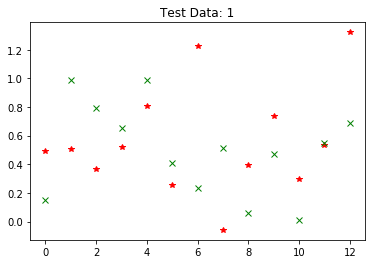

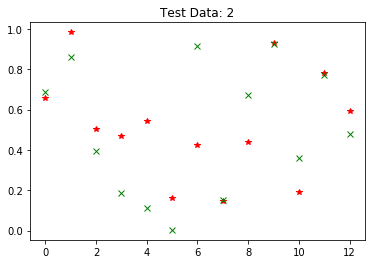

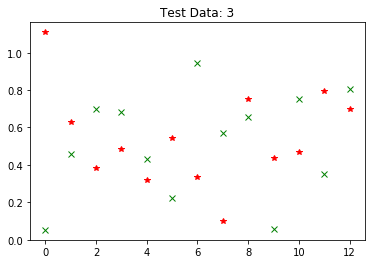

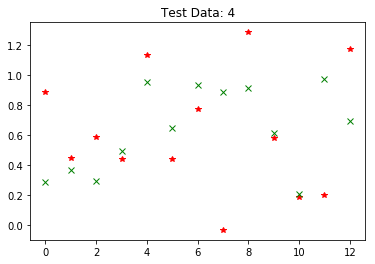

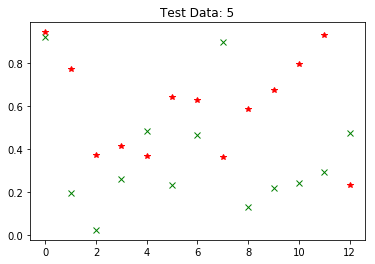

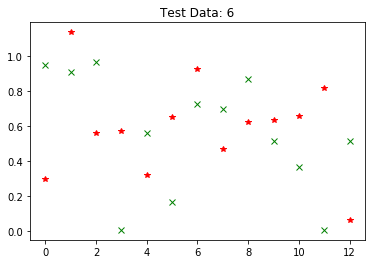

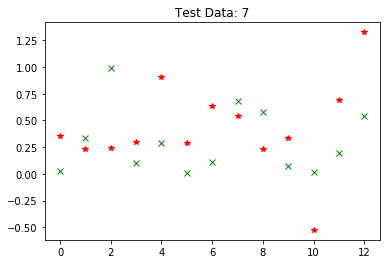

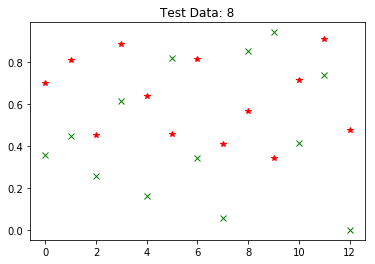

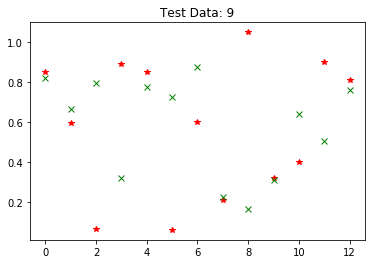

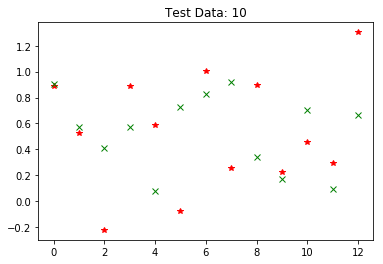

In [12]:
print('results.shape', results.shape)
print('y_test.shape', y_test.shape)

# mpld3.enable_notebook()
# plt.rcParams['figure.figsize'] = [6, 4]

for i, arr in enumerate(y_test[:10]):
    plt.title(f'Test Data: {i+1}')
    plt.plot(range(13), results[i], c='r', marker='*', ls='none')
    plt.plot(range(13), arr, c='g', marker='x', ls='none')
    plt.show()

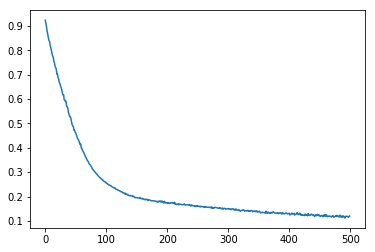

In [13]:
plt.plot(history.history['loss'])
plt.show()